Imports pyulog package. If this does not work, close Jupyter and run the following commands in the terminal 

In [3]:
import math
import pyulog
import numpy as np
from numpy.fft import rfft as rfft, rfftfreq as rfftfreq 
import pandas as pd

In [4]:
# for logs created by gazebo (simulation)
log_path = '/home/lucas/src/px4/Firmware/build/px4_sitl_default/tmp/rootfs/log'
log_date = '2019-08-14'
log_time = '13_14_23'
log_file = f'{log_path}/{log_date}/{log_time}.ulg'

# for real logs
log_path = '/home/lucas/Documents/Log_Analysis/Logs'
log_index = '14'
log_date = '2019-4-17'
log_time = '14_33_43'
log_file = f'{log_path}/log_{log_index}_{log_date}-{log_time}.ulg'
log_file = f'{log_path}/{log_time}.ulg'
print(log_file)

/home/lucas/Documents/Log_Analysis/Logs/14_33_43.ulg


In [12]:
ulog = pyulog.ULog(log_file) # creates a ULog object 

In [39]:
for msg in message_formats:
    print(msg)
    if msg == 'battery_status':
        print(message_formats[msg].fields)

actuator_controls_0
actuator_controls_1
actuator_outputs
airspeed
battery_status
[('uint64_t', 1, 'timestamp'), ('float', 1, 'voltage_v'), ('float', 1, 'voltage_filtered_v'), ('float', 1, 'current_a'), ('float', 1, 'current_filtered_a'), ('float', 1, 'average_current_a'), ('float', 1, 'discharged_mah'), ('float', 1, 'remaining'), ('float', 1, 'scale'), ('float', 1, 'time_remaining_s'), ('float', 1, 'temperature'), ('int32_t', 1, 'cell_count'), ('float', 4, 'voltage_cell_v'), ('float', 1, 'max_cell_voltage_delta'), ('uint16_t', 1, 'capacity'), ('uint16_t', 1, 'cycle_count'), ('uint16_t', 1, 'run_time_to_empty'), ('uint16_t', 1, 'average_time_to_empty'), ('uint16_t', 1, 'serial_number'), ('bool', 1, 'connected'), ('bool', 1, 'system_source'), ('uint8_t', 1, 'priority'), ('bool', 1, 'is_powering_off'), ('uint8_t', 1, 'warning'), ('uint8_t', 1, '_padding0')]
camera_capture
camera_trigger
cpuload
distance_sensor
ekf2_innovations
ekf_gps_drift
esc_status
esc_report
estimator_status
input_rc


In [14]:
datalist = ulog.data_list # is a list of Data objects, which contain the final topic data for a single topic and instance

In [17]:

for elem in datalist: # datalist has interesting attributes
    name = elem.name # is a string
    print('Topic name : ' + name) # displays all the names
    if(elem.name == 'vehicle_air_data'):
        value = elem.field_data # is a list of FieldData objects
        timestamp_idx = elem.timestamp_idx # is an int (dont)
        data = elem.data # is a dictionnary
    
    
        print(' Those are the FieldData objects :') # all existing datafields
        for element in value:
            print([' Value name : ' + element.field_name, 'Value type : ' + element.type_str])

Topic name : vehicle_status
Topic name : vehicle_land_detected
Topic name : sensor_combined
Topic name : manual_control_setpoint
Topic name : actuator_outputs
Topic name : actuator_outputs


In [16]:
topic_list = []
topic_list.append('sensor_combined')
topic_list.append('actuator_outputs')
topic_list.append('vehicle_local_position_setpoint')
topic_list.append('vehicle_status')
topic_list.append('vehicle_land_detected')
topic_list.append('manual_control_setpoint')
print(topic_list)

ulog = pyulog.ULog(log_file,topic_list) # creates a ULog object 
datalist = ulog.data_list # is a list of Data objects, which contain the final topic data for a single topic and instance

for topic in datalist: 
    if topic.name == 'sensor_combined': 
        data_sc = topic.data
    elif topic.name == 'actuator_outputs':
            if (np.all(topic.data['noutputs'] <= 1)): 
                continue
            else: 
                data_ao = topic.data
                print('Actuator outputs has been found')
    elif topic.name == 'vehicle_local_position_setpoint':
        data_vlps = topic.data
    elif topic.name == 'vehicle_status':
        data_vs = topic.data
        print('Vehicle status has been found')
    elif topic.name == 'vehicle_land_detected':
        data_vld = topic.data
    elif topic.name == 'manual_control_setpoint':
        data_mcs = topic.data

time_sc = data_sc['timestamp']/1e6 # convert it from us to s
time_ao = data_ao['timestamp']/1e6 
time_vs = data_vs['timestamp']/1e6 
time_vld = data_vld['timestamp']/1e6 
time_mcs = data_mcs['timestamp']/1e6
roll = data_sc['gyro_rad[0]']
pitch = data_sc['gyro_rad[1]']
yaw = data_sc['gyro_rad[2]']
acc_x=data_sc['accelerometer_m_s2[0]']
acc_y=data_sc['accelerometer_m_s2[1]']
acc_z=data_sc['accelerometer_m_s2[2]']
rpm1 = data_ao['output[0]']
rpm2 = data_ao['output[1]']
rpm3 = data_ao['output[2]']
rpm4 = data_ao['output[3]']
rpm5 = data_ao['output[4]']
rpm6 = data_ao['output[5]']
navstate = data_vs['nav_state']
stick_in_x = data_mcs['x']
stick_in_y = data_mcs['y']
stick_in_z = data_mcs['z']

['sensor_combined', 'actuator_outputs', 'vehicle_local_position_setpoint', 'vehicle_status', 'vehicle_land_detected', 'manual_control_setpoint']
Vehicle status has been found
Actuator outputs has been found


In [12]:
a = [1,2,3]
print(np.all(np.abs([1,-2,3])==[2,2,2]) and True)

False


# Hovering detection

In [6]:
from pyulgresample.ulogdataframe import DfUlg, TopicMsgs

topic_list = []
topic_list.append('vehicle_status')
topic_list.append('actuator_outputs')
topic_list.append('manual_control_setpoint')
topic_list.append('vehicle_local_position')

dfulg = DfUlg.create(log_file,topic_list)

msglist = []
for k in range(6):
    msglist.append(f'F_output_{k}')

z = dfulg.df['T_vehicle_local_position_0__F_z']

rpm1 = dfulg.df[f'T_actuator_outputs_0__{msglist[0]}']
rpm2 = dfulg.df[f'T_actuator_outputs_0__{msglist[1]}']
rpm3 = dfulg.df[f'T_actuator_outputs_0__{msglist[2]}']
rpm4 = dfulg.df[f'T_actuator_outputs_0__{msglist[3]}']
rpm5 = dfulg.df[f'T_actuator_outputs_0__{msglist[4]}']
rpm6 = dfulg.df[f'T_actuator_outputs_0__{msglist[5]}']

stick_in_x = dfulg.df['T_manual_control_setpoint_0__F_x']
stick_in_y = dfulg.df['T_manual_control_setpoint_0__F_y']
stick_in_z = dfulg.df['T_manual_control_setpoint_0__F_z']

navstate = dfulg.df['T_vehicle_status_0__F_nav_state']

## Hovering RPM averaging

In [3]:
hovering_bool=[]

for k in range(len(navstate)):
    ishover = False

    if navstate == 4: # Auto-loiter
        ishover = True 
    elif navstate == 2 and np.abs([stick_in_x, stick_in_y, stick_in_z]) <= [0.1, 0.1, 0.1]: # Position control
        ishover = True
    print(ishover)
    hovering_bool.append(ishover)
    
if np.all(hovering_bool == False):
    raise LogError(f'The drone does not hover in log {path}')
else:
    average_hovering_rpm1 = np.mean(rpm1[hovering_bool and z>1])
    average_hovering_rpm2 = np.mean(rpm2[hovering_bool and z>1])
    average_hovering_rpm3 = np.mean(rpm3[hovering_bool and z>1])
    average_hovering_rpm4 = np.mean(rpm4[hovering_bool and z>1])
    average_hovering_rpm5 = np.mean(rpm5[hovering_bool and z>1])
    average_hovering_rpm6 = np.mean(rpm6[hovering_bool and z>1])

average_hovering_rpm=np.mean([average_hovering_rpm1,average_hovering_rpm2,average_hovering_rpm3,average_hovering_rpm4,average_hovering_rpm5,average_hovering_rpm6])

print(average_hovering_rpm)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<IPython.core.display.Javascript object>


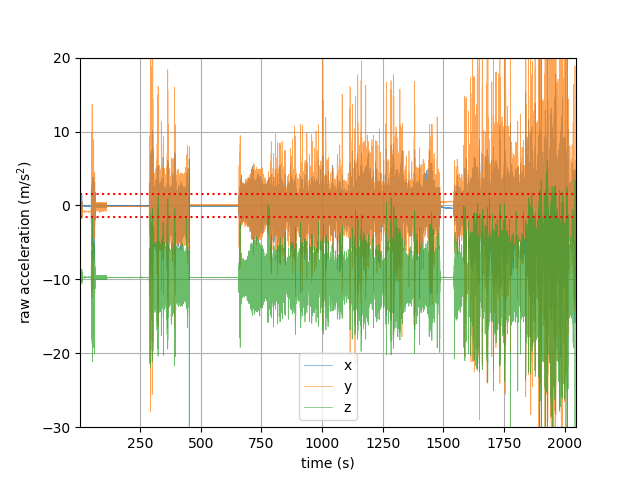

In [19]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib notebook
threshold = 1.5 # m/s^2

# Figure 1 : Local acceleration time plot
plt.figure()
plt.plot(time_sc,acc_x,label='x',linewidth=0.5,alpha=.7)
plt.plot(time_sc,acc_y,label='y',linewidth=0.5,alpha=.7)
plt.plot(time_sc,acc_z,label='z',linewidth=0.5,alpha=.7)
plt.axhline(threshold,linestyle=':',color='r')
plt.axhline(-threshold,linestyle=':',color='r')
plt.xlabel('time (s)')
plt.ylabel('raw acceleration (m/s$^2$)')
plt.grid()
plt.legend()
plt.axis([time_sc[0], time_sc[-1], -30, 20])
plt.show()

In [12]:
# score calculation for raw acceleration 
# we want to count the blank area between the zacc and the xacc or yacc as positive points, if they overlap as negative
max_acc_score = 9.81*len(time_sc) # having constantly the z at gravity and x,y at 0
acc_score = sum(np.min([acc_x[index],acc_y[index]])-acc_z[index] for index in range(len(time_sc)))/max_acc_score
print(f'acc score : {acc_score}') # should be above 0.5

acc score : 0.8902482955958091


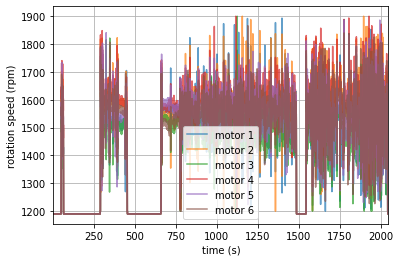

In [13]:
# Figure 2 : Rounds per minutes of the propellers over time
plt.figure()
plt.plot(time_ao,rpm1,label="motor 1",alpha=.7)
plt.plot(time_ao,rpm2,label="motor 2",alpha=.7)
plt.plot(time_ao,rpm3,label="motor 3",alpha=.7)
plt.plot(time_ao,rpm4,label="motor 4",alpha=.7)
plt.plot(time_ao,rpm5,label="motor 5",alpha=.7)
plt.plot(time_ao,rpm6,label="motor 6",alpha=.7)
plt.axis([time_ao[0], time_ao[-1], None, None])
plt.xlabel('time (s)')
plt.ylabel('rotation speed (rpm)')
plt.grid()
plt.legend()
plt.show()

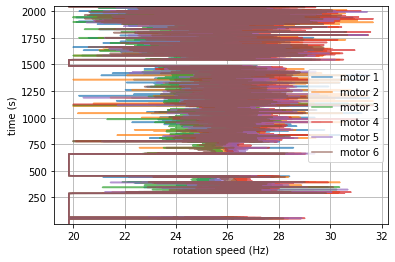

In [14]:
pfreq1 = rpm1/60 # convert to Hz
pfreq2 = rpm2/60
pfreq3 = rpm3/60
pfreq4 = rpm4/60
pfreq5 = rpm5/60
pfreq6 = rpm6/60

# Figure 3 ; time spent per frequency in Hertz
plt.figure()
plt.plot(pfreq1,time_ao,label="motor 1",alpha=.7)
plt.plot(pfreq2,time_ao,label="motor 2",alpha=.7)
plt.plot(pfreq3,time_ao,label="motor 3",alpha=.7)
plt.plot(pfreq4,time_ao,label="motor 4",alpha=.7)
plt.plot(pfreq5,time_ao,label="motor 5",alpha=.7)
plt.plot(pfreq6,time_ao,label="motor 6",alpha=.7)
plt.axis([None, None, time_ao[0], time_ao[-1]])
plt.xlabel('rotation speed (Hz)')
plt.ylabel('time (s)')
plt.grid()
plt.legend()
plt.show()

# Resampling using pandas

In [26]:
import pandas as pd
import datetime

columns = ['motor 1','motor 2','motor 3','motor 4','motor 5','motor 6']
rpm = pd.DataFrame(np.array([rpm1,rpm2,rpm3,rpm4,rpm5,rpm6]).transpose(), index = time_ao, columns = columns)

print(rpm)

             motor 1  motor 2  motor 3  motor 4  motor 5  motor 6
2.437762      1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
2.538566      1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
2.639391      1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
2.744169      1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
2.844998      1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
...              ...      ...      ...      ...      ...      ...
2045.702573   1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
2045.803364   1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
2045.904163   1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
2046.005757   1190.0   1190.0   1190.0   1190.0   1190.0   1190.0
2046.110557   1190.0   1190.0   1190.0   1190.0   1190.0   1190.0

[20102 rows x 6 columns]


In [54]:
print(rpm.index)

Float64Index([   2.437762,    2.538566,    2.639391,    2.744169,    2.844998,
                 2.945862,    3.046567,    3.148173,    3.248977,    3.349771,
              ...
              2045.193752, 2045.298574, 2045.399364, 2045.500957, 2045.601757,
              2045.702573, 2045.803364, 2045.904163, 2046.005757, 2046.110557],
             dtype='float64', length=20102)
2019-4-17


In [28]:
print(len(time_vs))
print(len(time_mcs))

for ti in range(len(time_vs)): 
    print([time_vs[ti], time_mcs[ti]])

2081
9850
[1.631568, 2.418401]
[2.636501, 2.637332]
[3.642454, 2.838363]
[4.652798, 3.019848]
[5.662446, 3.242391]
[6.664485, 3.441306]
[7.675496, 3.623307]
[7.744044, 3.844306]
[8.753378, 4.044309]
[9.764478, 4.227701]
[10.773961, 4.445443]
[11.785038, 4.647323]
[12.785648, 4.86832]
[13.79105, 5.069878]
[14.795611, 5.250922]
[15.325418, 5.473306]
[16.345102, 5.671717]
[17.348545, 5.852517]
[18.348607, 6.073333]
[19.355672, 6.2744]
[20.35846, 6.457372]
[21.367544, 6.678537]
[22.249639, 6.877415]
[22.260582, 7.060345]
[23.271385, 7.280523]
[24.277377, 7.482835]
[25.285446, 7.662734]
[26.29621, 7.902404]
[27.306601, 8.084789]
[28.310449, 8.308419]
[29.31959, 8.50732]
[30.325617, 8.687241]
[31.330473, 8.907717]
[32.33526, 9.08875]
[33.342549, 9.289583]
[34.345605, 9.510552]
[35.351538, 9.713811]
[36.35238, 9.894971]
[37.360232, 10.115464]
[38.369404, 10.314976]
[39.373442, 10.535491]
[40.378602, 10.739199]
[41.387595, 10.919328]
[42.39094, 11.139994]
[43.40064, 11.341662]
[44.41134, 11.51

In [55]:
print(log_date)
print(log_date.split('-'))

2019-4-17
['2019', '4', '17']


In [62]:
[year,month,day] = log_date.split('-')
[hour,minute,second] = log_time.split('-')
print(hour)

15


In [29]:
log_start_datetime = datetime.datetime(int(year),int(month),int(day),int(hour),int(minute),int(second))
print(log_start_datetime)
log_end_timedelta = datetime.timedelta(seconds=time_vs[-1])

index = pd.timedelta_range(log_start_datetime, log_start_datetime + log_end_timedelta, freq = f'{dt_vs}S')

NameError: name 'datetime' is not defined

In [29]:
t = datetime.time(0,time_vs)

TypeError: only size-1 arrays can be converted to Python scalars

In [9]:
dt_vs = np.mean(np.diff(time_vs))
dt_mcs = np.mean(np.diff(time_mcs))
print([dt_vs, dt_mcs])

[0.9815198350961539, 0.20749680322875416]


In [31]:
rpm.resample(1/dt_vs)

ValueError: Invalid frequency: 1.0188281115093671

# Resampling using pyulgresample

In [21]:
from pyulgresample.ulogdataframe import DfUlg, TopicMsgs

msglist = []
for k in range(6): 
    msglist.append(f'F_output_{k}')
    
dfulg = DfUlg.create(log_file,['vehicle_local_position'])
print(dfulg.df.columns)

Index(['timestamp', 'T_vehicle_local_position_0__F_ref_timestamp',
       'T_vehicle_local_position_0__F_ref_lat',
       'T_vehicle_local_position_0__F_ref_lon',
       'T_vehicle_local_position_0__F_x', 'T_vehicle_local_position_0__F_y',
       'T_vehicle_local_position_0__F_z',
       'T_vehicle_local_position_0__F_delta_xy_0',
       'T_vehicle_local_position_0__F_delta_xy_1',
       'T_vehicle_local_position_0__F_delta_z',
       'T_vehicle_local_position_0__F_vx', 'T_vehicle_local_position_0__F_vy',
       'T_vehicle_local_position_0__F_vz',
       'T_vehicle_local_position_0__F_z_deriv',
       'T_vehicle_local_position_0__F_delta_vxy_0',
       'T_vehicle_local_position_0__F_delta_vxy_1',
       'T_vehicle_local_position_0__F_delta_vz',
       'T_vehicle_local_position_0__F_ax', 'T_vehicle_local_position_0__F_ay',
       'T_vehicle_local_position_0__F_az', 'T_vehicle_local_position_0__F_yaw',
       'T_vehicle_local_position_0__F_ref_alt',
       'T_vehicle_local_position_0__F_

In [110]:
for msg in msglist:
    print(dfulg.df[f'T_actuator_outputs_0__{msg}'])

00:00:01.631568       NaN
00:00:02.427301       NaN
00:00:02.437762    1190.0
00:00:02.445302    1190.0
00:00:02.538566    1190.0
                    ...  
00:34:05.958112    1190.0
00:34:06.005757    1190.0
00:34:06.059298    1190.0
00:34:06.110557    1190.0
00:34:06.163077    1190.0
Name: T_actuator_outputs_0__F_output_0, Length: 42285, dtype: float32
00:00:01.631568       NaN
00:00:02.427301       NaN
00:00:02.437762    1190.0
00:00:02.445302    1190.0
00:00:02.538566    1190.0
                    ...  
00:34:05.958112    1190.0
00:34:06.005757    1190.0
00:34:06.059298    1190.0
00:34:06.110557    1190.0
00:34:06.163077    1190.0
Name: T_actuator_outputs_0__F_output_1, Length: 42285, dtype: float32
00:00:01.631568       NaN
00:00:02.427301       NaN
00:00:02.437762    1190.0
00:00:02.445302    1190.0
00:00:02.538566    1190.0
                    ...  
00:34:05.958112    1190.0
00:34:06.005757    1190.0
00:34:06.059298    1190.0
00:34:06.110557    1190.0
00:34:06.163077    1190.0
Na

In [34]:
z = dfulg.df['T_vehicle_local_position_0__F_z']
import datetime
print((z.index[-1]-z.index[0]) < datetime.timedelta(minutes=5))

True


# Real FFTs for acceleration and angles (data from sensor_combined)

In [1]:
# computing the frequency range of the accelerations
N = len(acc_z) # number of data points
dt = np.mean(np.diff(time_sc)) # average sampling time in
freq = rfftfreq(N,dt) # Hz
print(N)

# computing the amplitudes of the accelerations
acc_x_complex_spectrum = rfft(acc_x)
Ax = np.abs(acc_x_complex_spectrum)

acc_y_complex_spectrum = rfft(acc_y)
Ay = np.abs(acc_y_complex_spectrum)

acc_z_complex_spectrum = rfft(acc_z)
Az = np.abs(acc_z_complex_spectrum)

NameError: name 'acc_z' is not defined

In [2]:
# computing the amplitudes of the angles
roll_complex_spectrum = rfft(roll)
R = np.abs(roll_complex_spectrum)

pitch_complex_spectrum = rfft(pitch)
P = np.abs(pitch_complex_spectrum)

yaw_complex_spectrum = rfft(yaw)
Y = np.abs(yaw_complex_spectrum)

NameError: name 'rfft' is not defined

In [3]:
#define RPMMAX 1900 ~30Hz
#define RPMMIN 1200 ~20Hz

# Figure 4 : frequency spectrum of the acceleration
plt.figure()
plt.plot(freq,Ax,label='x',alpha=.7)
plt.plot(freq,Ay,label='y',alpha=.7)
plt.plot(freq,Az,label='z',alpha=.7)
plt.axis([0, freq[-1], 0, None])
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude')
plt.title('Acceleration spectrum')
plt.grid()
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
peak_limit = 20 #Hz
hf_limit = 500 #amplitude

# Figure 5 : frequency spectrum of the angles
plt.figure()
plt.plot(freq,R/1e3,label='roll',alpha=.7) #end index is NOT inclusive
plt.plot(freq,P/1e3,label='pitch',alpha=.7)
plt.plot(freq,Y/1e3,label='yaw',alpha=.7)
plt.axis([-5, freq[-1], 0, None])
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude * 1000')
plt.title('Angles spectrum')
plt.grid()
plt.legend()
plt.axhline(hf_limit/1e3,linestyle=':',color='r')
plt.axvline(peak_limit,linestyle=':',color='r')
plt.show()

## means above 40 Hz

In [ ]:
Rhf = []
for index in range(len(R)): 
    if freq[index] >= 40:
        Rhf.append(R[index])
    
Rmean = np.mean(Rhf)

print(f'mean roll above 40 Hz : {Rmean}')

Phf = []
for index in range(len(P)): 
    if freq[index] >= 40:
        Phf.append(P[index])
    
Pmean = np.mean(Phf)

print(f'mean pitch above 40 Hz : {Pmean}')

Yhf = []
for index in range(len(Y)): 
    if freq[index] >= 40:
        Yhf.append(Y[index])
    
Ymean = np.mean(Yhf)

print(f'mean yaw above 40 Hz : {Ymean}')

In [ ]:
# score calculation for angles spectrum
max_peak_score = peak_limit*np.sum((P>=hf_limit) | (R>=hf_limit) | (Y>=hf_limit))
peak_score = np.sum([peak_limit - freq[np.argmax([P[index],R[index],Y[index]])] for index in range(N//2) if ((P[index]>=hf_limit) |(R[index]>=hf_limit) |(Y[index]>=hf_limit))])/max_peak_score
print(f'peak score :{peak_score}')

max_hf_score = hf_limit*(N - np.argmax(freq.__gt__(peak_limit)))
# for each frequency above peak_limit, take the distance between hf_limit and the highest curve and sum them
hf_score = np.sum([hf_limit - np.max([R[index],P[index],Y[index]]) for index in range(N//2) if (freq[index]>peak_limit) ])/max_hf_score
print(f'hf score : {hf_score}')

print(max_peak_score)
print(max_hf_score)

In [ ]:
score_index=[]
for index in range(N-1):
    if ((P[index]>=hf_limit)|(R[index]>=hf_limit)|(Y[index]>=hf_limit)):
        upper = hf_limit
        lower = np.max([R[index],P[index],Y[index]])
        score_index.append(upper - lower)
        print(lower)
score_hf = sum(score_index)
print(score_hf/max_hf_score)

In [ ]:
np.sum((P>=hf_limit) | (R>=hf_limit) | (Y>=hf_limit))

In [ ]:
dtmax = np.max(dt) # looking for the longest time interval between two sampletimes
print(dtmax)
print(f'the average sampling time is : {np.mean(dt)}s') # average sample time in s
# the highest achievable resolution in frequency is twice the inverse the longest dt
print(1/(2*dtmax)) # max freq in rad
print(1/(2*dtmax)*360/(2*math.pi)) #Hz

In [ ]:
import os
import csv 
print(os.listdir())
csv_file = open('log_scores.csv')
if not csv_file.readline() == 'Log File,Acc score,Peak score,HF score\n':
    print('The headline is not the correct one')
else:
    print('The headline is correct')